# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [61]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import logging
import os
import os.path as op
import tarfile
from scipy.stats import randint
from six.moves import urllib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedShuffleSplit, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [64]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier
from ta_lib.housing import data_prep  as dp

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [65]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [73]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [74]:
context.config["params"]

{'parameters': {'XGBoost': {'gamma': [0.03],
   'min_child_weight': [6],
   'learning_rate': [0.1],
   'max_depth': [3],
   'n_estimators': [500]}}}

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [75]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(4128, 10) (4128, 1)
(4128, 10) (4128, 1)


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [76]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [77]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(4128, 10)
(4128, 10)


#### Encoding


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [78]:
save_dataset(context, train_X, 'processed/housing/features')
save_dataset(context, train_y, 'processed/housing/target')

In [79]:
housing=train_X.copy()
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [80]:
housing_prepared=dp.data_prep(train_X)

In [81]:
housing_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.575070,-0.696573,0.032956,2.155858,1.324706,0.817501,1.404346,2.565291,1.890326,0.745801,-0.437913,-0.892368,1.0,0.0,0.0,0.0,0.0
1,-0.434801,-0.334668,-0.362981,-0.322671,-0.623843,-0.587521,-0.645584,0.685576,0.942177,0.980252,0.034493,-0.970250,1.0,0.0,0.0,0.0,0.0
2,0.545222,-0.635472,0.587268,-0.640115,-0.726107,-0.637210,-0.669807,0.325915,-0.005972,-0.049426,-0.018065,-0.442271,1.0,0.0,0.0,0.0,0.0
3,0.719338,-0.795274,0.508081,-0.528142,-0.574093,-0.358108,-0.591080,-0.313603,-0.005972,0.066115,0.376521,-0.273937,1.0,0.0,0.0,0.0,0.0
4,1.231735,-1.331081,0.745643,0.662134,0.224674,0.089088,0.356671,0.308104,-0.005972,0.434315,-0.336713,-0.806490,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,1.122291,-0.884575,-0.758918,-0.195021,-0.292175,-0.215386,-0.388207,-0.574328,-0.954121,0.408755,0.198264,-0.377928,1.0,0.0,0.0,0.0,0.0
4124,0.649691,-0.757673,0.349706,-0.958119,-0.659774,-0.148782,-0.648612,-0.950938,-0.954121,-1.240797,0.972937,1.841447,1.0,0.0,0.0,0.0,0.0
4125,-0.086570,-0.546171,1.141580,-0.456479,-0.527106,-0.790504,-0.418487,0.507526,0.942177,-0.220898,-0.705735,-0.345473,1.0,0.0,0.0,0.0,0.0
4126,0.813858,-0.926876,0.112144,-0.294118,-0.333634,-0.348593,-0.254977,0.629616,0.942177,-0.192111,-0.217103,-0.237657,1.0,0.0,0.0,0.0,0.0


In [14]:
##housing_prepared = housing_prepared.rename_column("ocean_proximity_<1H OCEAN","ocean_proximity_L1H OCEAN")

- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [15]:
reports.feature_analysis(housing_prepared,'./reports/model_experimenting/feature_analysis_report.html')

this method is deprecated in favour of `Styler.to_html()`


### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [16]:
out = eda.get_correlation_table(housing_prepared)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.975869,0.975869
1,income_cat,median_income,0.941349,0.941349
2,latitude,longitude,-0.925426,0.925426
3,total_bedrooms,total_rooms,0.918777,0.918777
4,households,total_rooms,0.918387,0.918387
5,households,population,0.911955,0.911955
6,population,total_bedrooms,0.879341,0.879341
7,population,total_rooms,0.850422,0.850422
8,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,-0.609911,0.609911


In [17]:
out = eda.get_bivariate_plots(housing_prepared, x_cols=["rooms_per_household"], y_cols=list(num_columns)[1])
out

:Scatter   [rooms_per_household]   (latitude)

In [18]:
%%time
# create reports as needed
cols = housing_prepared.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(housing_prepared, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='./reports/model_experimenting/feature_analysis_bivariate')

CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 15.1 s


A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1WSGT3586tY-rOmZ57xGILbmL5ll9cSVT/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1A2fz_bjYv8I3iaFDT75JQSDKeJEXxCtp/view?usp=sharing)

In [19]:
reports.feature_interactions(housing_prepared,'.reports/model_experimenting/feature_interaction_report.html')

this method is deprecated in favour of `Styler.to_html()`


### 3.2.3 Key Drivers - Interaction with Target variable

In [20]:
out = eda.get_target_correlation(housing_prepared, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Key drivers report like feature importance, bivariate plots can be obtained as below

In [21]:
reports.key_drivers(housing_prepared,train_y, './reports/model_experimenting/key_drivers_report.html', y_continuous=True)


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1209MzmSSEhiTYuPfHpaVXFXUVbkaJm0B/view?usp=sharing)

In [22]:
reports.data_exploration(housing_prepared,train_y,'./reports/model_experimenting/data_exploration_report.html', y_continuous=True)

this method is deprecated in favour of `Styler.to_html()`


## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [23]:
##housing_prepared = housing_prepared.rename_column("ocean_proximity_<1H OCEAN","ocean_proximity_L1H OCEAN")
cols = list(housing_prepared.columns)
vif = eda.calc_vif(housing_prepared)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(housing_prepared[cols])

In [24]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [25]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [26]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(housing_prepared, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f18a13a19d0>,
                                     kw_args={'cols2keep': ['longitude',
                                                            'housing_median_age',
                                                            'total_bedrooms',
                                                            'population',
                                                            'median_income',
                                                            'income_cat',
                                                            'rooms_per_household',
                                                            'bedrooms_per_room',
                                                            'population_per_household',
                                                            'ocean_proximity_<1H '
                                                            'OCEAN',
                                                            'ocean_proximity_INLAND',
                                                            'ocean_proximity_ISLAND',
                                                            'ocean_proximity_NEAR '
                                                            'BAY',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN']})),
                ('estimator', SKLStatsmodelOLS())])

In [27]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     620.0
Date:                Wed, 08 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:31:12   Log-Likelihood:                -51690.
No. Observations:                4128   AIC:                         1.034e+05
Df Residuals:                    4114   BIC:                         1.035e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   2.082e+05   6465.460     32.204      0.000    1.96e+05    2.21e+05
longitude                  -4416.9551   1213.714     -3.639      0.000   -6796.490   -2037.420
housing_median_age           1.53e+04   1194.652     12.808      0.000     1.3e+04    1.76e+04
total_bedrooms              4.849e+04   2610.059     18.580      0.000    4.34e+04    5.36e+04
population                 -4.245e+04   2605.154    -16.296      0.000   -4.76e+04   -3.73e+04
median_income               9.169e+04   3148.828     29.118      0.000    8.55e+04    9.79e+04
income_cat                 -9412.0642   3104.759     -3.031      0.002   -1.55e+04   -3325.058
rooms_per_household        -3824.6516   1331.460     -2.873      0.004   -6435.034   -1214.269
bedrooms_per_room            484.7150   1183.449      0.410      0.682   -1835.485    2804.915
population_per_household    1.037e+04   1428.361      7.262      0.000    7572.850    1.32e+04
ocean_proximity_<1H OCEAN   1.665e+04   6626.688      2.513      0.012    3662.560    2.96e+04
ocean_proximity_INLAND     -4.797e+04   6713.410     -7.146      0.000   -6.11e+04   -3.48e+04
ocean_proximity_ISLAND      1.957e+05   3.21e+04      6.106      0.000    1.33e+05    2.59e+05
ocean_proximity_NEAR BAY    1.293e+04   7153.170      1.807      0.071   -1097.046     2.7e+04
ocean_proximity_NEAR OCEAN  3.088e+04   6879.881      4.488      0.000    1.74e+04    4.44e+04
==============================================================================
Omnibus:                      759.807   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1734.901
Skew:                           1.045   Prob(JB):                         0.00
Kurtosis:                       5.391   Cond. No.                     1.25e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.41e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [28]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])
test_X = load_dataset(context, 'test/housing/features')
lr_test_X =dp.data_prep(test_X)

In [29]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=housing_prepared, y_train=train_y, x_test= lr_test_X, y_test= test_y,refit=True)
reg_linear_report.get_report(include_shap=False, file_path='./reports/model_experimenting/regression_linear_model_report')

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
this method is deprecated in favour of `Styler.to_html()`


In [30]:
threshold=0.3
residual_analysis = lr_test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(lr_test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [31]:
residual_analysis.hvplot.kde(y="rooms_per_household",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="rooms_per_house_hold",
                                title=f'rooms_per_house_hold(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [rooms_per_household]   (Density)

## decision tree

In [32]:
# let's find features for some decent defaults
estimator = DecisionTreeRegressor()
dtree_training_pipe_init = Pipeline([
    ('D_tree', DecisionTreeRegressor())
])
dtree_training_pipe_init.fit(housing_prepared, train_y)

Pipeline(steps=[('D_tree', DecisionTreeRegressor())])

<Axes: >

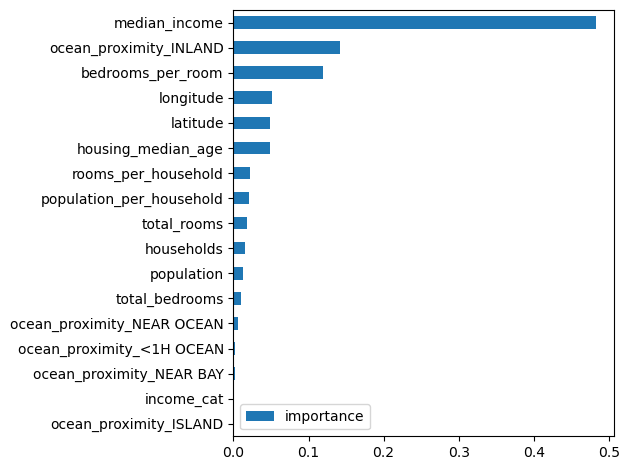

In [33]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': dtree_training_pipe_init['D_tree'].feature_importances_})
imp.index = housing_prepared.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

##imp_features_dtree = list(set(list(housing_prepared.columns)) - set(['ocean_proximity_NEAR OCEAN','ocean_proximity_L1H OCEAN',
                                          'income_cat','ocean_proximity_NEAR BAY', 'ocean_proximity_ISLAND'])) # not used currently

In [34]:
dtree_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('DecisionTree Regression', DecisionTreeRegressor())
])
test_X = load_dataset(context, 'test/housing/features')

dt_test_X = dp.data_prep(test_X)

##dt_test_X = dt_test_X.rename_column("ocean_proximity_<1H OCEAN","ocean_proximity_L1H OCEAN")



In [35]:
dt_test_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.575070,-0.696573,0.032956,1.602218,1.025754,0.614330,1.104803,2.358455,1.890326,0.731012,-0.436991,-0.884249,1.0,0.0,0.0,0.0,0.0
1,-0.434801,-0.334668,-0.362981,-0.285055,-0.534263,-0.495927,-0.556024,0.617359,0.942177,0.962667,0.033956,-0.961419,1.0,0.0,0.0,0.0,0.0
2,0.545222,-0.635472,0.587268,-0.526772,-0.616136,-0.535191,-0.575650,0.284222,-0.005972,-0.054727,-0.018440,-0.438265,1.0,0.0,0.0,0.0,0.0
3,0.719338,-0.795274,0.508081,-0.441510,-0.494433,-0.314643,-0.511866,-0.308135,-0.005972,0.059435,0.374929,-0.271470,1.0,0.0,0.0,0.0,0.0
4,1.231735,-1.331081,0.745643,0.464824,0.145064,0.038734,0.255990,0.267724,-0.005972,0.423243,-0.336103,-0.799156,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,1.122291,-0.884575,-0.758918,-0.187856,-0.268728,-0.201863,-0.347501,-0.549633,-0.954121,0.397987,0.197222,-0.374511,1.0,0.0,0.0,0.0,0.0
4124,0.649691,-0.757673,0.349706,-0.768916,-0.563029,-0.149232,-0.558477,-0.898470,-0.954121,-1.231885,0.969503,1.824580,1.0,0.0,0.0,0.0,0.0
4125,-0.086570,-0.546171,1.141580,-0.386942,-0.456815,-0.656325,-0.372033,0.452440,0.942177,-0.224154,-0.703986,-0.342352,1.0,0.0,0.0,0.0,0.0
4126,0.813858,-0.926876,0.112144,-0.263313,-0.301920,-0.307125,-0.239559,0.565526,0.942177,-0.195710,-0.216863,-0.235521,1.0,0.0,0.0,0.0,0.0


In [36]:
desc_tree_report = RegressionReport(model=dtree_ppln, x_train=housing_prepared, y_train=train_y, x_test= dt_test_X, y_test= test_y,refit=True)
reg_linear_report.get_report(include_shap=False, file_path='./reports/model_experimenting/regression_DecisionTree_model_report')

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
this method is deprecated in favour of `Styler.to_html()`


**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [37]:
test_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
0,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,<1H OCEAN,5
1,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,<1H OCEAN,4
2,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,<1H OCEAN,3
3,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,<1H OCEAN,3
4,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,NEAR OCEAN,3
...,...,...,...,...,...,...,...,...,...,...
4123,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,<1H OCEAN,2
4124,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,<1H OCEAN,2
4125,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,<1H OCEAN,4
4126,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,<1H OCEAN,4


In [38]:
threshold=0.3
residual_analysis = dt_test_X.copy()
residual_analysis['prediction'] = dtree_ppln.predict(dt_test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [39]:
residual_analysis.hvplot.kde(y="rooms_per_household",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="rooms_per_house_hold",
                                title=f'rooms_per_house_hold(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [rooms_per_household]   (Density)

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

### 4.2.2 Model Pipeline Build

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

In [40]:
housing_prepared = housing_prepared.rename_column("ocean_proximity_<1H OCEAN","ocean_proximity_L1H OCEAN")
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(housing_prepared, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<Axes: >

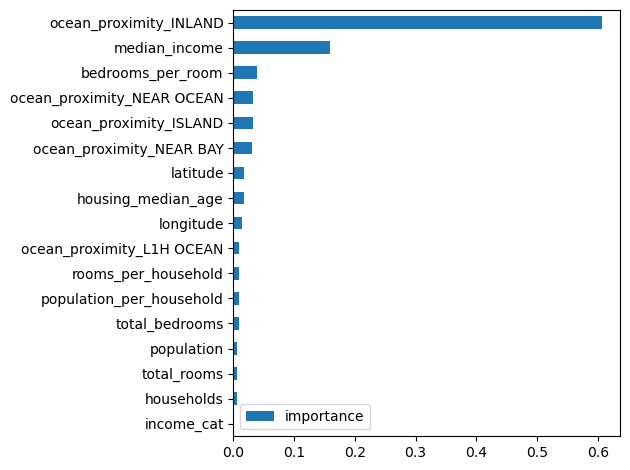

In [41]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = housing_prepared.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

##### Pipeline build based on new importance features

In [42]:
# let's find features for some decent defaults
imp_features = ['ocean_proximity_INLAND','median_income','bedrooms_per_room','ocean_proximity_NEAR OCEAN','ocean_proximity_ISLAND','ocean_proximity_NEAR BAY']

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [43]:
context.config["params"]['parameters']['XGBoost']

{'gamma': [0.03],
 'min_child_weight': [6],
 'learning_rate': [0.1],
 'max_depth': [3],
 'n_estimators': [500]}

In [44]:
%%time
parameters = context.config["params"]['parameters']['XGBoost']
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(housing_prepared, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/omkar3913/miniconda3/envs/capstone-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/omkar3913/miniconda3/envs/capstone-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/omkar3913/miniconda3/envs/capstone-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/omkar3913/miniconda3/envs/capstone-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarn

0.789197071905007
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 5.06 s, sys: 0 ns, total: 5.06 s
Wall time: 2.78 s


#### Pipeline Build using the best estimator

In [45]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(housing_prepared, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f18a13a19d0>,
                                     kw_args={'cols2keep': ['ocean_proximity_INLAND',
                                                            'median_income',
                                                            'bedrooms_per_room',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'ocean_proximity_ISLAND',
                                                            'ocean_proximity_NEAR '
                                                            'BAY']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_...
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [46]:
test_X = load_dataset(context, 'test/housing/features')

xgb_test_X = dp.data_prep(test_X)

xgb_test_X = xgb_test_X.rename_column("ocean_proximity_<1H OCEAN","ocean_proximity_L1H OCEAN")

In [47]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=housing_prepared, y_train=train_y, x_test= xgb_test_X, y_test= test_y,refit=True)
reg_tree_report.get_report(include_shap=False, file_path='./reports/model_experimenting/regression_tree_model_report')

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
this method is deprecated in favour of `Styler.to_html()`


The Regression report containing the feature importances are available [here](https://drive.google.com/file/d/1JBfL3uxPcxBfl0amweXBFmLr7CSHFBUO/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [48]:
housing_prepared = housing_prepared.rename_column("ocean_proximity_L1H OCEAN","ocean_proximity_<1H OCEAN")

In [49]:
housing_prepared.drop_duplicates(inplace=True)

In [50]:
model_pipelines = [reg_ppln,dtree_ppln,xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=housing_prepared, y=train_y.values,refit=True)
metrics = model_comparison_report.get_report(file_path='./reports/model_experimenting/regression_comparison')


`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


ValueError: Shape of passed values is (4128, 1), indices imply (4128, 14)

In [ ]:
model_comparison_report.performance_metrics

##4.2 RANDOM FOREST

In [52]:
estimator = RandomForestRegressor()
rf_training_pipe_init = Pipeline([
    ('ran_forest', RandomForestRegressor())
])
rf_training_pipe_init.fit(housing_prepared, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Pipeline(steps=[('ran_forest', RandomForestRegressor())])

In [55]:
import optuna


In [58]:
import mlflow
from optuna.integration.mlflow import MLflowCallback

In [60]:
from sklearn.model_selection import cross_val_score
mlflc = MLflowCallback(
    tracking_uri="/d/regression_py/regression-py/mlruns",
    metric_name="Accuracy",
    mlflow_kwargs={"nested": True}
)

def objective(trial):
    data = func_wrap()
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    max_features = trial.suggest_int('max_features', 2, 8)
    
    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features = max_features)
    
    return cross_val_score(clf, data[0], data[1], n_jobs=-1, cv=5).mean()

data_op = [housing_prepared, np.array(train_y["median_house_value"])]

def func_wrap(d = data_op):
    return d
    
study = optuna.create_study(study_name="RandomForest",direction='maximize')
study.optimize(objective, n_trials=5, callbacks=[mlflc])

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
[I 2023-03-08 19:17:19,603] A new study created in memory with name: RandomForest
[I 2023-03-08 19:17:20,971] Trial 0 finished with value: 0.637518267890137 and parameters: {'n_estimators': 3, 'max_depth': 5.722066855086019, 'max_features': 5}. Best is trial 0 with value: 0.637518267890137.
2023/03/08 19:17:21 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest' does not exist. Creating a new experiment.
[I 2023-03-08 19:17:23,313] Trial 1 finished with value: 0.7537601395710231 and parameters: {'n_estimators': 13, 'max_depth': 17.992416621931067, 'max_features': 5}. Best is trial 1 with value: 0.7537601395710231.
[I 2023-03-08 19:17:24,586] Trial 2 finished with value: 0.3481933643538956 and parameters: {'n_estimators': 8, 'max_depth': 1.53357765988187, 'max_features': 6}. Best is trial 1 with value: 0.7537601395710231.
[I 2023-03-08 19:17:26,251] Trial 3 finished with value: 0.

Accuracy: 0.757948845296244
Best hyperparameters: {'n_estimators': 14, 'max_depth': 28.771159139740178, 'max_features': 4}


A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1LDibiFap9K4DKME-Y0S0mtI_05lTdaJF/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat